<a href="https://colab.research.google.com/github/hashPhoeNiX/ColabNotebooks/blob/master/Marine_Invertebrates_Indentification_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

* Downloading the dataset from zindi.africa
* Splitting the data into train and validation set

In [ ]:
# Downloading the dataset from zindi.africa

import requests
import requests, zipfile

url = 'https://api.zindi.africa/v1/competitions/umojahack-1-saeon-identifying-marine-invertebrates/files/train_small.zip'
myobj = {'auth_token': 'hgoZ8xHAxMRXd8burfPrPaWe'}

x = requests.post(url, data = myobj,stream=True)
target_path = 'train.zip'

handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

In [ ]:
# Unzipping the data

# !unzip train.zip

In [ ]:
# !pip install split-folders tqdm

In [ ]:
# Splitting the data into train, test and validation set
import split_folders

split_folders.ratio('train_small', output='data', seed=1337, ratio=(.8, .1, .1))

Copying files: 3111 files [00:00, 4863.64 files/s]


## Importing the necessary libraries

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *

from torchvision import datasets, transforms, models
from torch.utils.data import random_split
import torch

In [ ]:
bs = 64

In [ ]:
path = Path('data/')
path.ls()

[PosixPath('data/val'), PosixPath('data/train'), PosixPath('data/test')]

torch.Size([3, 384, 512])


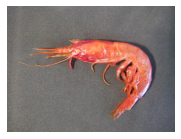

In [ ]:
img = open_image(path/'train'/'Aristeus_varidens'/'1M6SJTQ.jpeg')
print(img.data.shape)
img.show()

In [ ]:
tfms = get_transforms()
np.random.seed(42)
data = ImageDataBunch.from_folder(path, 
                                  train='train',
                                  valid = 'val',
                                  size=299, 
                                  bs=16, 
                                  ds_tfms=tfms).normalize(imagenet_stats)

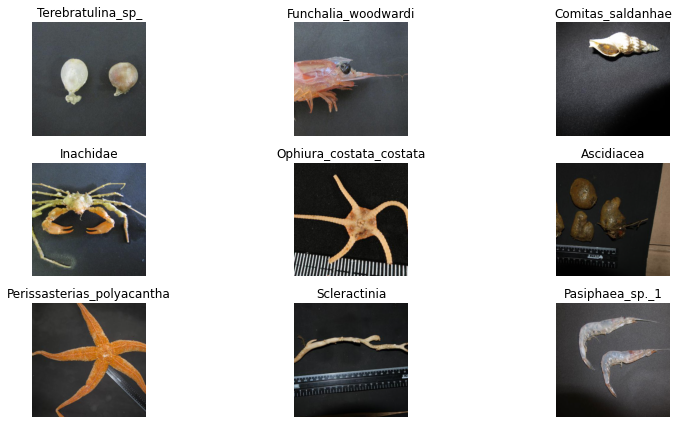

In [ ]:
data.show_batch(3, figsize=(12, 6))

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds)

(137, 2437, 262)

### Training the Model

Getting the pretrained model from a given architecture with a custom head suitable for the dataset.

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], model_dir="model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 5.75E-03


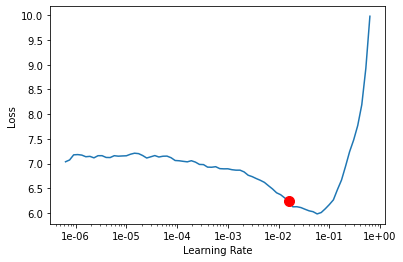

In [ ]:
# finding the learning rate

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1.58E-02
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.522051,4.129687,0.732824,0.267176,05:11
1,3.697458,2.410772,0.568702,0.431298,00:55
2,2.109840,1.443352,0.374046,0.625954,00:55
3,1.267922,0.885898,0.213740,0.786260,00:54
4,0.822183,0.761681,0.187023,0.812977,00:53


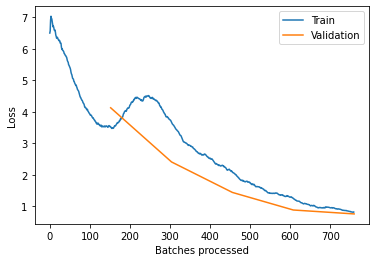

In [ ]:
learn.recorder.plot_losses()

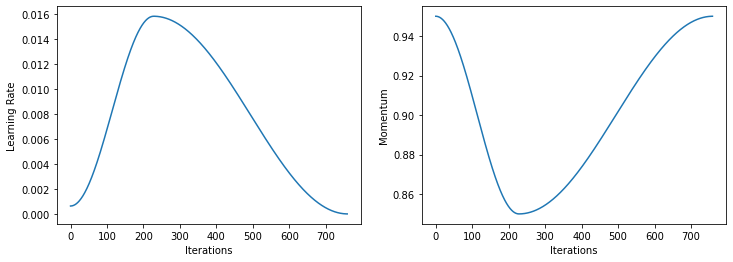

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('first_step')

Fitting the model following the [1cycle](https://arxiv.org/pdf/1803.09820.pdf) policy. 

### Training the Unfrozen Model

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.91E-07


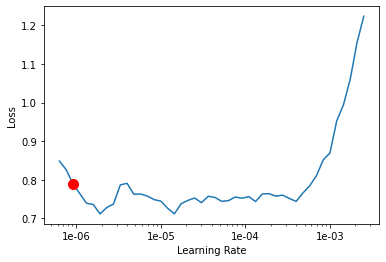

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.692520,0.715884,0.187023,0.812977,00:57
1,0.702567,0.803316,0.202290,0.797710,00:58
2,0.820141,0.743318,0.198473,0.801527,00:57
3,0.632822,0.650295,0.167939,0.832061,00:58
4,0.530648,0.603239,0.145038,0.854962,00:59
5,0.416650,0.625945,0.167939,0.832061,00:58
6,0.287960,0.615412,0.152672,0.847328,00:59
7,0.202515,0.596759,0.148855,0.851145,00:59
8,0.151355,0.561033,0.148855,0.851145,00:58
9,0.145319,0.557208,0.129771,0.870229,00:57


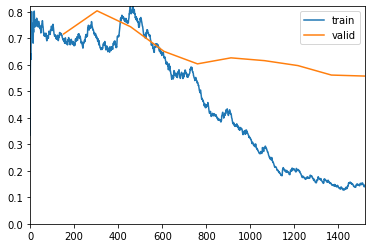

Better model found at epoch 0 with accuracy value: 0.8129770755767822.
Better model found at epoch 3 with accuracy value: 0.8320610523223877.
Better model found at epoch 4 with accuracy value: 0.8549618124961853.
Better model found at epoch 9 with accuracy value: 0.8702290058135986.


In [ ]:
learn.fit_one_cycle(10, slice(9.12E-07, lr/5), callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='accuracy', every='improvement', name='bestmodel')])

In [ ]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 0.5572077631950378


Saving and loading models

In [ ]:
# learn.save('new_best')

In [ ]:
learn.load('new_best')

Learner(data=ImageDataBunch;

Train: LabelList (2437 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Pteraster_capensis,Pteraster_capensis,Pteraster_capensis,Pteraster_capensis,Pteraster_capensis
Path: data;

Valid: LabelList (262 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Pteraster_capensis,Pteraster_capensis,Pteraster_capensis,Porifera,Porifera
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

Interpretation methods for the classification models. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
len(data.valid_ds)==len(losses)==len(idxs)

True

Plotting the top losses along with their prediction, actual, loss, and probability of actual class.

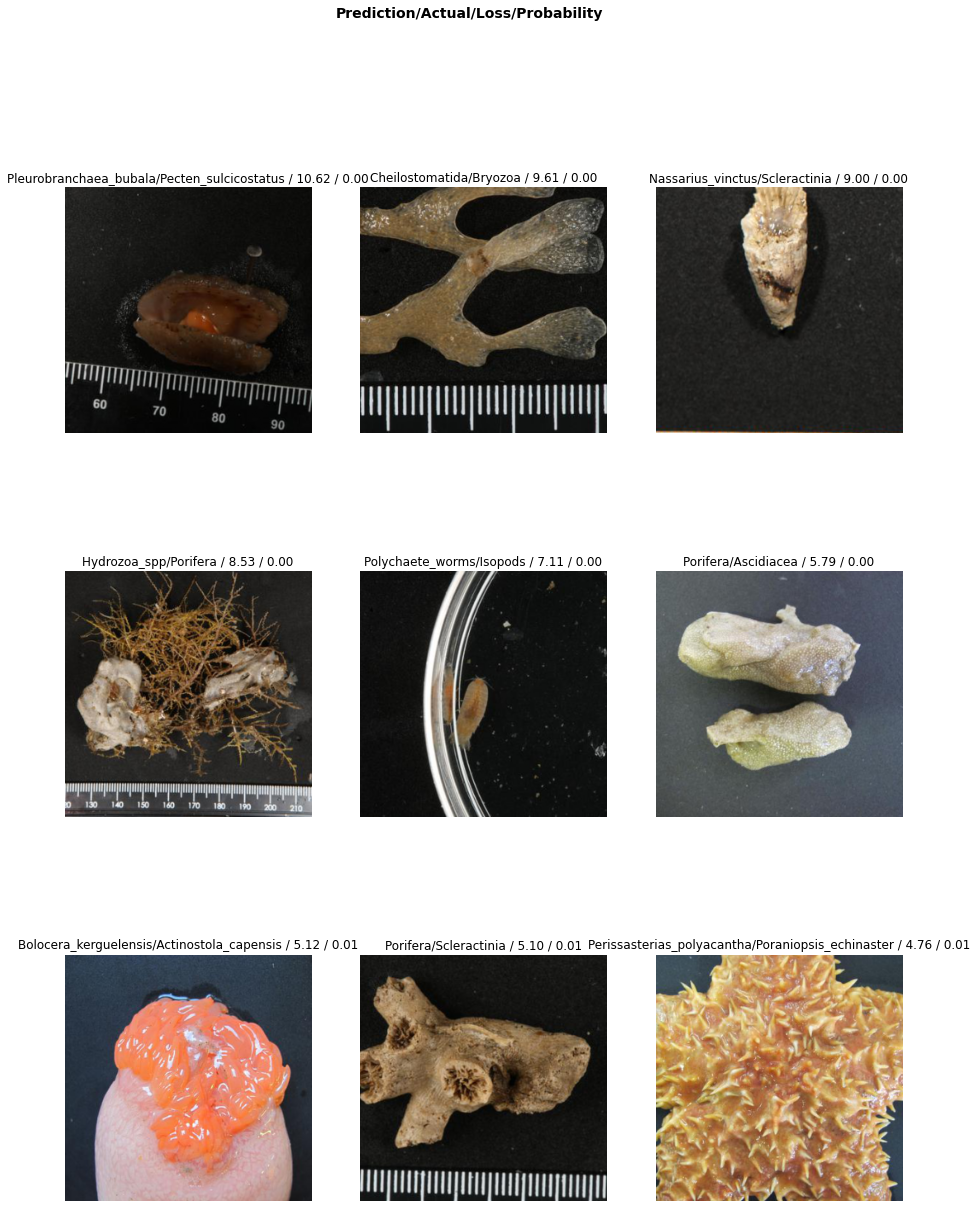

In [ ]:
interp.plot_top_losses(9, figsize=(15,20))

Test Time Augmentation

The average if the regular predictions with the average of prediction obtained through augmented versions of the train set is taken and the accuracy is determined


In [ ]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

tensor(0.8626)

Checking the accuracy on the train and validation set

In [ ]:
train_pred, y = learn.get_preds(ds_type=DatasetType.Train)
accuracy(train_pred, y)

tensor(0.9979)

In [ ]:
valid_pred, target = learn.get_preds(ds_type=DatasetType.Valid)
accuracy(valid_pred, target)

tensor(0.8702)

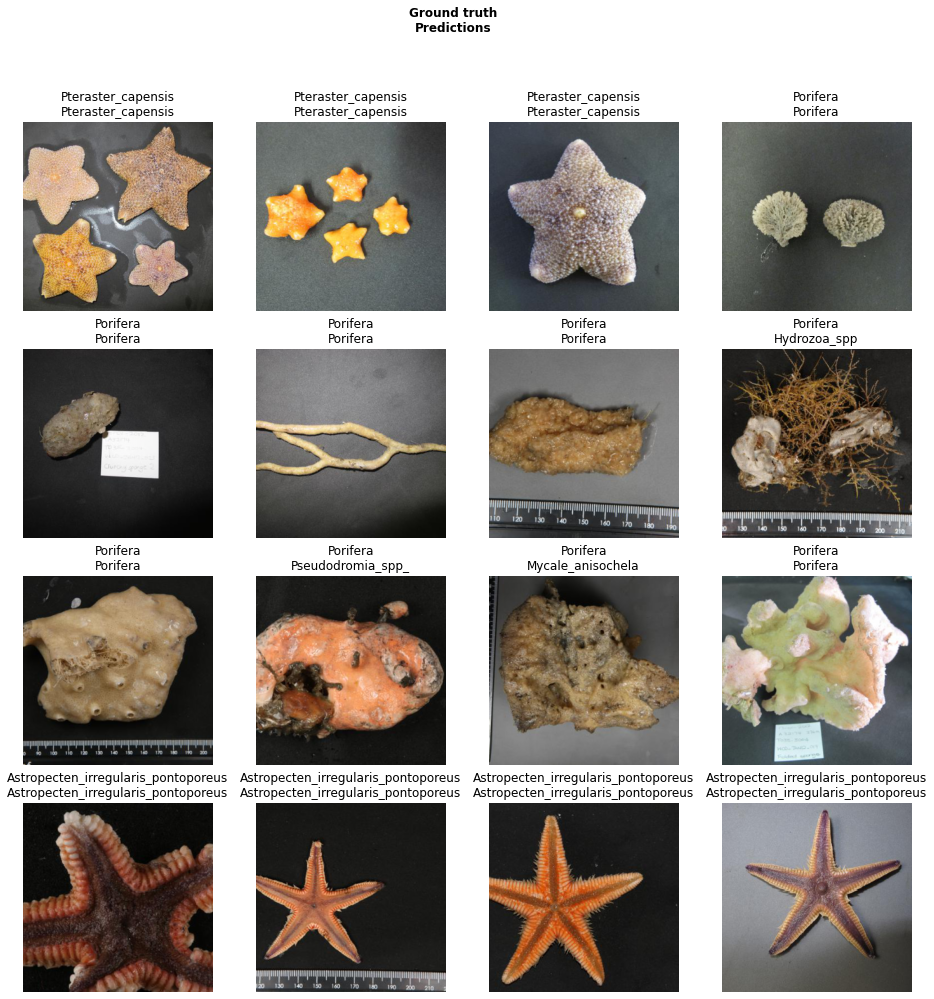

In [ ]:
learn.show_results(ds_type=DatasetType.Valid)